In [7]:
import pandas
import numpy
import librosa

from matplotlib import pyplot as plt
import librosa.display

import allosaurus
import panphon

In [43]:
def parse_timestamp_output(output):
    records = []
    lines = output.split('\n')
    for line in lines:
        tok = line.split(' ')
        start = float(tok[0])
        duration = float(tok[1])
        end = start + duration
        label = tok[2]
        records.append(dict(start=start, end=end, label=label))
    df = pandas.DataFrame.from_records(records)
    return df

def is_consonant(ipa):
    ft = panphon.FeatureTable()
    cons = ft.word_fts(ipa)[0] >= {'cons': 1}
    return cons

def phone_recognize_file(path, emit=1.2, lang='eng'):

    model = allosaurus.app.read_recognizer()
    out = model.recognize(path, lang, timestamp=True, emit=emit)
    
    phones = parse_timestamp_output(out)
    phones['consonant'] = phones['label'].apply(is_consonant)
    phones['color'] = phones['consonant'].replace({True: 'green', False: 'red'})
    return phones

path = './english.wav'
phones = phone_recognize_file(path)
phones.head()

,start,end,label,consonant,color
0,0.42,0.465,h,True,green
1,0.51,0.555,ə,False,red
2,0.57,0.615,l,True,green
3,0.66,0.705,o,False,red
4,0.75,0.795,w,False,red


(134,)


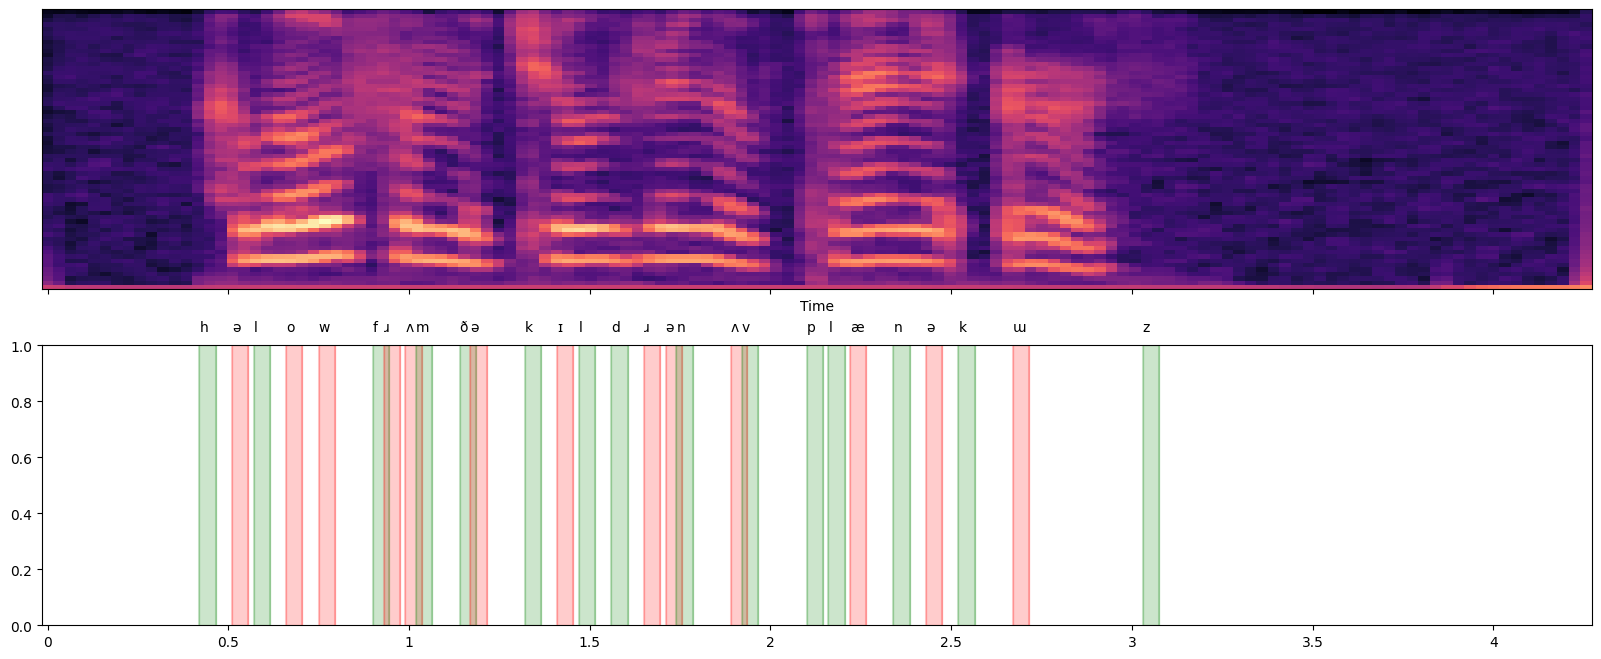

In [44]:
def load_spectrogram(path, hop_length=1024, sr=16000, n_mels=64, ref=numpy.max, **kwargs):
    y, sr = librosa.load(path, sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, **kwargs)
    S_db = librosa.power_to_db(S, ref=ref)
    tt = numpy.arange(0, S_db.shape[1]) * (hop_length / sr)
    print(tt.shape)
    df = pandas.DataFrame(S_db.T, index=pandas.Series(tt, name='time'))
    return df

def plot_events(ax, df, start='start', end='end', color=None, annotate=None,
                label=None, alpha=0.2, zorder=-1,
                text_kwargs={}, **kwargs):

    import itertools
    palette = itertools.cycle(seaborn.color_palette())
    
    def valid_time(dt):
        return not pandas.isnull(dt)

    for idx, row in df.iterrows():
        s = row[start]
        e = row[end]
        
        if color is None:
            c = next(palette)
        else:
            c = row[color]
        
        label = None
        if valid_time(s) and valid_time(e):
            ax.axvspan(s, e, label=label, color=c, alpha=alpha, zorder=zorder)
        if valid_time(e):
            ax.axvline(e, label=label, color=c, alpha=alpha, zorder=zorder)
        if valid_time(s):
            ax.axvline(s, label=label, color=c, alpha=alpha, zorder=zorder)

        import matplotlib.transforms
        trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
        if annotate is not None:
            ax.text(s, 1.05, row[annotate], transform=trans, **text_kwargs)

hop_length = 512
spectrogram = load_spectrogram(path, hop_length=hop_length, fmax=4000)

fig, (spec_ax, label_ax) = plt.subplots(2, figsize=(20, 8), sharex=True)
librosa.display.specshow(spectrogram.T.values, ax=spec_ax, sr=16000, fmax=4000, hop_length=hop_length, x_axis='time')
plot_events(label_ax, phones, color='color', annotate='label')

fig.savefig('output.png')